# Data Preparation - Vektorisierung
Ziel dieses Jupyter Notebooks ist die Erstellung eines vektorisierten Datensatzes, der als Eingabe für das Machine Learning Modell genutzt werden kann.

## Eingaben
Externe Eingabe dieses Juypter Notebooks ist bereinigter `panda.Dataframe`, der aus einer .h5 Datei geladen wird. Weitere Eingabe werden im Abschnitt Parameter durch den Benutzer festgelegt.

## Ausgabe
Das Skript generiert die folgenden drei Dateien, die in einem gemeinsamen Unterverzeichnis abgelegt werden:
* x.h5 : `numpy.array` - Rohdaten in Matrix Gestalt
* y.h5 : `numpy.array` - Label zu den Beispielen
* sample_nr.h5 : `numpy.array` - Samplenummer des Beispiels im ursprünglichen Dataframe an

Während die Indizierung im übergebenen `pandas.Dataframe` per Samplenummer erfolgt, werden Beispiel in den Ausgaben per Index indiziert.

### Rohdaten
Die Rohdaten sind von der Gestalt `(n, t, f)` mit
* n: Anzahl Beispiele
* t: Anzahl Zeitpunkte
* f: Anzahl Features

Diese Nomenklatur entspricht der Eingabe Shape der rekurrenten Layer in der keras API.

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.ndimage
import sklearn.preprocessing
import matplotlib.pyplot as plt

## Pfad

In [3]:
dataframe_file = "df_torque.h5"
output_folder= "torque_l400_s2"

# get the working directory of the ipykernel
working_dir = os.getcwd()

# define subdirectories
data_path = os.path.join(working_dir, "data")
output_path = os.path.join(data_path, output_folder)
source = os.path.join(data_path, dataframe_file)

## Parameter

### Metadaten

### Variierende Sequenzlängen

1. Ausschlusskriterien
2. Cropping and Padding
3. Uniform Scaling


### Downsampling


In [4]:

# Compute a moving average using a window of width 'smoothing'
smoothing = 2
# Target length of the sequence after zooming and downspampling
sequence_length = 400

## Funktionen

In [5]:
def moving_average(array, window=2):
    """Compute the moving average by means of a discrete convolution
    
    As a result of computing the moving average, the lenght of the series
    is reduced by window-1.
    """
    if window < 1:
        raise ValueError("Cannot compute a moving average for a window smaller than 1")
    return np.convolve(array, np.ones(window)/window, mode="valid")

def moving_average_vec(array, window):
    """Using grouped convolutions, compute the moving averages more efficiently.
    Computes the moving average for each channel individually.
    
    Note: Currently not supported on M1 CPU
    
    Parameters
    ----------
    array : numpy.array
        Array of equidistant timeseries of several channels: shape= [time x channels]
    """
    
    if window < 1:
        raise ValueError("Cannot compute a moving average for a window smaller than 1")
    
    assert len(array.shape) == 2
    channels = array.shape[-1]
    
    # grouped 1D convolution
    array = array.reshape(1,-1,channels)
    return tf.nn.conv1d(array, filters=np.ones((window,1,channels)),stride=1,padding="VALID")/window    

def timeseries_scale(data, scaled_length):
    """Scales a timeseries uniformly along the time axis.
    
    
    Parameters
    ----------
    data : numpy.array
        A single timeseries of a batch of timeseries. The first dimension
        of the numpy array corresponds to the time axis
        
    scaled_length : int
        The output length > 0 of the timeseries.
    """  
    
    time_scale = scaled_length / data.shape[0]
    
    zoom = None
    if len(data.shape) > 1:
        zoom = (time_scale,1)
    else:
        zoom = (time_scale,)
    
    return scipy.ndimage.zoom(data, zoom, mode='nearest')

def normalize_x(x):
    for feature in range(x.shape[2]):
        data = x[:,:,feature]
        data = sklearn.preprocessing.normalize(data, axis=1, norm="max")
        x[:,:,feature] = data
    return x

## Dataframe laden

In [6]:
# Read the pandas.Dataframe
df = pd.read_hdf(source)
df

,screwdriver_torque,label
sample_nr,,
2,0.061,0.0
2,0.061,0.0
2,0.061,0.0
2,0.061,0.0
2,0.061,0.0
...,...,...
4094,0.016,0.0
4094,0.016,0.0
4094,0.016,0.0


### Shapes
Ermittle die shape der Ausgabeartefakte:

In [7]:
# number of samples
num_samples = len(df.groupby(level=0).size())

# timeseries length
num_timesteps = sequence_length

# number of features
# only vectorize columns with numeric (non-boolean) values
column_names = list(col_name for col_name in df.columns if df[col_name].dtype != bool)
column_names.remove("label")
num_features = len(column_names)

x_shape = (num_samples, num_timesteps, num_features)

### Ausgabeartefakte
Liest zunächst die Daten x sowie die zugehörigen Labels.

In [8]:
# labels
y = df.groupby(level=0).aggregate({"label": lambda x: x.iloc[0]}).to_numpy().reshape(-1)

# data x
x = np.zeros(x_shape)
for i, (_, sample_df) in enumerate(df.groupby(level=0)):
    
    raw = sample_df[column_names].to_numpy()
    smoothed = np.zeros((raw.shape[0]-smoothing+1, raw.shape[1]))
    
    # smoothing the timeseries
    for j in range(num_features):
        # TODO: replace the for-loop once grouped convolutions are supported
        smoothed[:,j] = moving_average(raw[:,j], window=smoothing)
        
    # optional: do some padding and cropping here
        
    # downsampling
    downsampled = timeseries_scale(smoothed, num_timesteps)
    
    x[i, :, :] = downsampled
    
x = normalize_x(x)

sample_nr_df = df.drop(columns=df.columns)
sample_nr_df.reset_index(inplace=True)
sample_nr = sample_nr_df.groupby(["sample_nr"]).aggregate({"sample_nr": lambda x: x.iloc[0]}).to_numpy().reshape(-1)

In [9]:
Path(output_path).mkdir(parents=True, exist_ok=True)

np.save(os.path.join(output_path, "x.npy"), x)
np.save(os.path.join(output_path, "y.npy"), y)
np.save(os.path.join(output_path, "sample_nr.npy"), sample_nr)

In [10]:
x.shape
df

,screwdriver_torque,label
sample_nr,,
2,0.061,0.0
2,0.061,0.0
2,0.061,0.0
2,0.061,0.0
2,0.061,0.0
...,...,...
4094,0.016,0.0
4094,0.016,0.0
4094,0.016,0.0


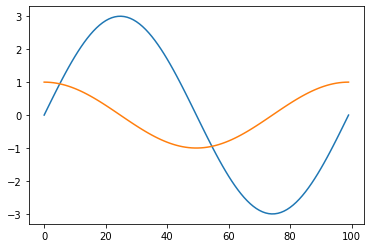

In [11]:
import sklearn.preprocessing

d = np.array([3*np.sin(np.linspace(0,2*np.pi,100)), np.cos(np.linspace(0,2*np.pi,100))])
#d = d.reshape((d.shape)+(1,))
plt.plot(d[0,:])
plt.plot(d[1,:])
plt.show()

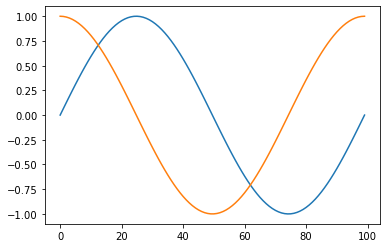

In [12]:
dn = sklearn.preprocessing.normalize(d, axis=1, norm="max")
plt.plot(dn[0,:])
plt.plot(dn[1,:])
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = np.a